<a href="https://colab.research.google.com/github/yohanesnuwara/pyresim/blob/master/simulators/PyReSim1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!git clone https://github.com/yohanesnuwara/pyresim

Cloning into 'pyresim'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 1186 (delta 94), reused 0 (delta 0), pack-reused 1031
Receiving objects: 100% (1186/1186), 597.30 KiB | 8.66 MiB/s, done.
Resolving deltas: 100% (719/719), done.


In [3]:
import sys
sys.path.append('/content/pyresim/functions')

In [4]:
from input_output import read_input, read_depth
from boundary import boundary_floweq1d
from gridding import source1d
from solver import lhs_coeffs1d_welltype, rhs_constant1d_welltype
from transmissibility import transmissibility1d, transmissibility1d_boundary
from wellblock import fraction_wellblock_geometric_factor
from wellsimulation import solution_well1d
from potential import potential_term1d

Additional input for Slightly Compressible simulation

In [14]:
from wellsimulation import well1d_report_slicomp

## Incompressible Simulation

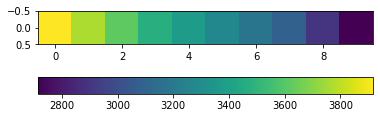

In [27]:
import warnings
warnings.filterwarnings("ignore")

"""""""""""
INPUT TXT DATA
"""""""""""

filepath = '/content/pyresim/input/intermediate/intermediate1d_input.txt'
depthpath = '/content/pyresim/input/basic/basic1d_depth.txt'

# call the read_input function to read input data
reservoir_input, wells, west, east = read_input(filepath)

"""""""""""
ADD ELEVATION

N.b.: there are 2 approaches to add elevation in case of ELEVATED grid block
      * upload the depth input file using function 'read_depth'
      * create synthetic depth data using Numpy method in Python
"""""""""""

## Read or create synthetic depth data
x, depth = read_depth(depthpath)

## Boundary depth (if not elevated, leave both with ZEROS)
## then add to the 'west_boundary' and 'east_boundary' already created before
west_depth, east_depth = 0, 0
west['depth'] = west_depth 
east['depth'] = east_depth

"""""""""""
INPUT PROCESSING
"""""""""""

# number of blocks in x and y
xi = reservoir_input['xi']

# define parameters, in this case blocks are homogeneous and same in size
dx = reservoir_input['dx'] 
dy = reservoir_input['dy']
dz = reservoir_input['dz']
kx = reservoir_input['kx']
B = reservoir_input['B']
mu = reservoir_input['mu']
rho = reservoir_input['rho']

# well information (dataframe)
well_name = wells['well_name']
well_rw = wells['well_rw'] / 12  # wellbore radius, inch to ft
well_skin = wells['well_skin']
well_loc = wells['well_loc']
well_condition = wells['well_rw']
well_value = wells['well_value']
well_config = wells['well_config']

"""""""""""
GRIDDING
"""""""""""

# calculate elevation
elev = [j - i for i, j in zip(depth[:-1], depth[1:])]


"""""""""""
WELL INFORMATION PROCESSING
"""""""""""

# source block (production or injection well)
well_loc = np.array(well_loc).astype(int)
qsc = source1d(well_value, well_loc, xi)  # call function HERE

# Calculate wellblock geometric factor
kh, r_eq, Gw = [], [], []

for i in range(len(well_config)):
    kh_, r_eq_, Gw_ = fraction_wellblock_geometric_factor(dx, dy, kx, kx, well_skin[i],
                                                          well_rw[i], dz, well_config[i])
    kh.append(kh_);
    r_eq.append(r_eq_);
    Gw.append(Gw_)

# create dataframe from the created dictionary
well_df = pd.DataFrame.from_dict(wells)

well_mu = np.full(len(well_loc), mu)
well_B = np.full(len(well_loc), B)
well_dz = np.full(len(well_loc), dz)

well_df['well_loc'] = well_loc
well_df['well_dz'] = dz
well_df['well_kh'] = kh
well_df['well_mu'] = mu
well_df['well_B'] = B
well_df['well_Gw'] = Gw

"""""""""""
SIMULATION
"""""""""""

lhs_mat = np.array([[0.] * xi] * xi)
rhs_mat = np.array([[0.] * 1] * xi)

for i in range(xi):

    T_min, T_plus = transmissibility1d(dx, dy, dz, kx, mu, B)

    if i == 0:
        # left boundary

        ## flow rate from boundary
        qsc_b = boundary_floweq1d(west['type'], dx, dy, dz, kx, mu, B, value=west['value'], no_block=(i + 1))

        ## LHS coeffs
        T_plus = T_plus
        T_min = transmissibility1d_boundary(west['type'], dx, dy, dz, kx, mu, B)

        p_plus, p_min, p = lhs_coeffs1d_welltype('west', (i + 1), well_df, qsc, T_plus, T_min, solver='incompressible')

        ## calculate potential term for the RHS constant
        potential_term = potential_term1d(rho, T_min, T_plus, west['depth'], depth[i], depth[i + 1])

        ## RHS constants
        rhs = rhs_constant1d_welltype(west['type'], (i + 1), well_df, potential_term, qsc_b, T_pb=T_min,
                                    p_b=west['value'], solver='incompressible')

        ## fill in LHS matrix (lhs_mat)
        lhs_mat[i, i] = p
        lhs_mat[i, i + 1] = p_plus

        ## fill in RHS matrix (rhs_mat)   
        rhs_mat[i, 0] = rhs

    elif i == xi - 1:
        # right boundary

        ## flow rate from boundary
        qsc_b = boundary_floweq1d(east['type'], dx, dy, dz, kx, mu, B, value=east['value'], no_block=(i + 1))

        ## LHS coeffs
        T_plus = transmissibility1d_boundary(east['type'], dx, dy, dz, kx, mu, B)
        T_min = T_min
        p_plus, p_min, p = lhs_coeffs1d_welltype('east', (i + 1), well_df, qsc, T_plus, T_min, solver='incompressible')

        ## calculate potential term for the RHS constant
        potential_term = potential_term1d(rho, T_min, T_plus, depth[i - 1], depth[i], east['depth'])

        ## RHS constants        
        rhs = rhs_constant1d_welltype(east['type'], (i + 1), well_df, potential_term, qsc_b,
                                    T_pb=T_plus, p_b=east['value'], solver='incompressible')

        ## fill in LHS matrix (lhs_mat)
        lhs_mat[i, i - 1] = p_min
        lhs_mat[i, i] = p

        ## fill in RHS matrix (rhs_mat)    
        rhs_mat[i, 0] = rhs

    else:

        ## calculate potential term for the RHS constant

        T_plus, T_min = T_plus, T_min
        p_plus, p_min, p = lhs_coeffs1d_welltype(None, (i+1), well_df, qsc, T_plus, T_min, solver='incompressible') 

        ## calculate potential term for the RHS constant
        potential_term = potential_term1d(rho, T_min, T_plus, depth[i - 1], depth[i], depth[i + 1])

        ## RHS constants      
        rhs = -qsc[i] + potential_term

        ## fill in LHS matrix (lhs_mat)
        lhs_mat[i, i - 1] = p_min
        lhs_mat[i, i] = p
        lhs_mat[i, i + 1] = p_plus

        ## fill in RHS matrix (rhs_mat)    
        rhs_mat[i, 0] = rhs  

"""""""""""
PRESSURE SOLVER
"""""""""""

p_sol = np.linalg.solve(lhs_mat, rhs_mat)

"""""""""""
DISPLAY PRESSURE
"""""""""""

p_sol = p_sol.T.reshape(-1)
p_sol_ = np.expand_dims(p_sol, axis=0)  # or axis=1
plt.imshow(p_sol_)
plt.colorbar(orientation='horizontal')
plt.show() 

In [7]:
"""""""""""
WELL SIMULATION
"""""""""""

well_report = solution_well1d(well_df, p_sol)
well_report = well_report.drop(['well_dz', 'well_kh', 'well_mu', 'well_B', 'well_Gw'], 1)
well_report

,well_name,well_loc,well_rw,well_skin,well_condition,well_value,well_config,fbhp_sol,rate_sol
0,A,4,3.5,0.0,constant_rate,-150.0,0.0,3524.200400,-150.0
1,B,8,3.5,0.0,constant_rate,350.0,0.0,3294.229104,350.0
2,C,10,3.5,0.0,constant_rate,-100.0,0.0,2833.736051,-100.0


## Slightly Compressible Simulation

In [28]:
import warnings
warnings.filterwarnings("ignore")

"""""""""""
PUT THE INPUT TXT DATA
"""""""""""

filepath = '/content/pyresim/input/intermediate/intermediate1d_input.txt'

# call the read_input function to read input data
reservoir_input, wells, west, east = read_input(filepath)
depthpath = '/content/pyresim/input/basic/basic1d_depth.txt'

"""""""""""
SLIGHTLY INCOMPRESSIBLE INPUTS
"""""""""""

p_initial = np.full(reservoir_input['xi'], 4000) # initial pressure
timestep = 1 # time increment, day
schedule = 20 # how long will be simulated, days

"""""""""""
ADD ELEVATION

N.b.: there are 2 approaches to add elevation in case of ELEVATED grid block
      * upload the depth input file using function 'read_depth'
      * create synthetic depth data using Numpy method in Python
"""""""""""

## Read or create synthetic depth data
x, depth = read_depth(depthpath)

## Boundary depth (if not elevated, leave both with ZEROS)
## then add to the 'west_boundary' and 'east_boundary' already created before
west_depth, east_depth = 0, 0
west['depth'] = west_depth 
east['depth'] = east_depth

"""""""""""
INPUT PROCESSING
"""""""""""

# number of blocks in x and y
xi = reservoir_input['xi']

# define parameters, in this case blocks are homogeneous and same in size
dx = reservoir_input['dx'] 
dy = reservoir_input['dy']
dz = reservoir_input['dz']
kx = reservoir_input['kx']
B = reservoir_input['B']
mu = reservoir_input['mu']
rho = reservoir_input['rho']

# well information (dataframe)
well_name = wells['well_name']
well_rw = wells['well_rw'] / 12  # wellbore radius, inch to ft
well_skin = wells['well_skin']
well_loc = wells['well_loc']
well_condition = wells['well_rw']
well_value = wells['well_value']
well_config = wells['well_config']

" For Slightly Incompressible sim, there are information of CFLUID and CPORE "

# convert unit microsip to sip (* 10^-6)
reservoir_input['cfluid'] = reservoir_input['cfluid'] * 1E-6
reservoir_input['cpore'] = reservoir_input['cpore'] * 1E-6

"""""""""""
GRIDDING
"""""""""""

# calculate elevation
elev = [j - i for i, j in zip(depth[:-1], depth[1:])]

"""""""""""
WELL INFORMATION PROCESSING
"""""""""""

# source block (production or injection well)
well_loc = np.array(well_loc).astype(int)
qsc = source1d(well_value, well_loc, xi)  # call function HERE

# Calculate wellblock geometric factor
kh, r_eq, Gw = [], [], []

for i in range(len(well_config)):
    kh_, r_eq_, Gw_ = fraction_wellblock_geometric_factor(dx, dy, kx, kx, well_skin[i],
                                                          well_rw[i], dz, well_config[i])
    kh.append(kh_);
    r_eq.append(r_eq_);
    Gw.append(Gw_)

# create dataframe from the created dictionary
well_df = pd.DataFrame.from_dict(wells)

well_mu = np.full(len(well_loc), mu)
well_B = np.full(len(well_loc), B)
well_dz = np.full(len(well_loc), dz)

well_df['well_loc'] = well_loc
well_df['well_dz'] = dz
well_df['well_kh'] = kh
well_df['well_mu'] = mu
well_df['well_B'] = B
well_df['well_Gw'] = Gw

"""""""""""
SIMULATION
"""""""""""

" Produce LHS matrix. In Slightly Compressible simulation, LHS can be assumed CONSTANT "

lhs_mat = np.array([[0.] * xi] * xi)

# set up empty array for boundary flow rate, and two transmissibilities 
# for later computation of RHS and pressure solve at each timestep

qsc_b_array = []; T_min_array = []; T_plus_array = []

for i in range(xi):

    T_min, T_plus = transmissibility1d(dx, dy, dz, kx, mu, B)

    if i == 0:
        # left boundary

        ## flow rate from boundary
        qsc_b = boundary_floweq1d(west['type'], dx, dy, dz, kx, mu, B, value=west['value'], no_block=(i + 1))

        ## LHS coeffs
        T_plus = T_plus
        T_min = transmissibility1d_boundary(west['type'], dx, dy, dz, kx, mu, B)

        p_plus, p_min, p = lhs_coeffs1d_welltype('west', (i + 1), well_df, qsc, T_plus, T_min,
                                                 solver='slicomp', reservoir_input=reservoir_input, 
                                                 timestep=timestep)
        qsc_b_array.append(qsc_b)
        T_min_array.append(T_min)
        T_plus_array.append(T_plus)        

        ## fill in LHS matrix (lhs_mat)
        lhs_mat[i, i] = p
        lhs_mat[i, i + 1] = p_plus

    elif i == xi - 1:
        # right boundary

        ## flow rate from boundary
        qsc_b = boundary_floweq1d(east['type'], dx, dy, dz, kx, mu, B, value=east['value'], no_block=(i + 1))

        ## LHS coeffs
        T_plus = transmissibility1d_boundary(east['type'], dx, dy, dz, kx, mu, B)
        T_min = T_min

        p_plus, p_min, p = lhs_coeffs1d_welltype('east', (i + 1), well_df, qsc, T_plus, T_min,
                                                 solver='slicomp', reservoir_input=reservoir_input, 
                                                 timestep=timestep)  

        qsc_b_array.append(qsc_b)
        T_min_array.append(T_min)
        T_plus_array.append(T_plus)  

        ## fill in LHS matrix (lhs_mat)
        lhs_mat[i, i - 1] = p_min
        lhs_mat[i, i] = p


    else:
        # interior block
        T_plus, T_min = T_plus, T_min
        p_plus, p_min, p = lhs_coeffs1d_welltype(None, (i+1), well_df, qsc, T_plus, T_min,
                                                 solver='slicomp', reservoir_input=reservoir_input, 
                                                 timestep=timestep)

        qsc_b_array.append(qsc_b)
        T_min_array.append(T_min)
        T_plus_array.append(T_plus)                                                           

        ## fill in LHS matrix (lhs_mat)
        lhs_mat[i, i - 1] = p_min
        lhs_mat[i, i] = p
        lhs_mat[i, i + 1] = p_plus

" Timestep evolution of computing RHS and solving the pressure "

# initiate solution pressure with the initial pressure array (p_initial)
p_sol = p_initial

p_sol_record = []
for k in range(schedule):

  rhs_mat = np.array([[0.] * 1] * xi)  
  for i in range(xi):
    # the pressure in grid block. FIRST timestep, it equals 'p_initial'
    # the NEXT timesteps, it equals the solved and updated pressure   
    p_sol = p_sol

    if i == 0:
        # left boundary

        ## calculate potential term for the RHS constant
        potential_term = potential_term1d(rho, T_min_array[i], T_plus_array[i], west['depth'], depth[i], depth[i + 1])

        ## RHS constants
        rhs = rhs_constant1d_welltype(west['type'], (i + 1), well_df, potential_term, qsc_b_array[i], T_pb=T_min_array[i],
                                    p_b=west['value'], solver='slicomp', p_initial=p_sol[i],
                                    reservoir_input=reservoir_input, timestep=timestep)

        ## fill in RHS matrix (rhs_mat)   
        rhs_mat[i, 0] = rhs

    elif i == xi - 1:
        # right boundary                                               

        ## calculate potential term for the RHS constant
        potential_term = potential_term1d(rho, T_min_array[i], T_plus_array[i], depth[i - 1], depth[i], east['depth'])

        ## RHS constants       
        rhs = rhs_constant1d_welltype(east['type'], (i + 1), well_df, potential_term, qsc_b_array[i],
                                    T_pb=T_plus_array[i], p_b=east['value'], solver='slicomp', p_initial=p_sol[i],
                                    reservoir_input=reservoir_input, timestep=timestep) 

        ## fill in RHS matrix (rhs_mat)    
        rhs_mat[i, 0] = rhs

    else:   
        # interior blocks

        ## calculate potential term for the RHS constant
        potential_term = potential_term1d(rho, T_min_array[i], T_plus_array[i], depth[i - 1], depth[i], depth[i + 1])

        # RHS constants
        # add term 
        Vb = reservoir_input['dx'] * reservoir_input['dy'] * reservoir_input['dz']
        ct = reservoir_input['cpore'] + reservoir_input['cfluid']
        rhs_term = (Vb * reservoir_input['poro'] * ct) / (5.614583 * reservoir_input['B'] * timestep) 

        rhs = (-qsc[i] + potential_term) - (rhs_term * p_sol[i])

        ## fill in RHS matrix (rhs_mat)    
        rhs_mat[i, 0] = rhs 

  """""""""""
  PRESSURE SOLVER
  """""""""""
  p_sol = np.linalg.solve(lhs_mat, rhs_mat)  
  p_sol_record.append(p_sol) 

"""""""""""
OUTPUT
"""""""""""

p_sol_ = []

for i in range(len(p_sol_record)):
  p_sol = p_sol_record[i].T.reshape(-1)
  p_sol = np.expand_dims(p_sol, axis=0)
  p_sol_.append(p_sol)  

# merge the initial pressure to the solved pressure afterwards
p_initial_ = p_initial.reshape((1,1,xi))
p_sol_ = np.concatenate((p_initial_, p_sol_), axis=0)

In [29]:
"""""""""""
INTERACTIVE ANIMATION
"""""""""""

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, ToggleButtons
import ipywidgets as widgets

min, max = np.round(np.amin(p_sol_)), np.round(np.amax(p_sol_))

@interact

def display_pressure(day=(0, schedule)):
  fig, ax = plt.subplots()  
  im = ax.imshow(p_sol_[day], vmin=min, vmax=max)
  ax.set_title('Pressure at day {}'.format(day))
  cax = fig.add_axes([0.1, 0.2, 0.8, 0.05])
  fig.colorbar(im, cax=cax, orientation='horizontal')

  # # add values on the grid blocks
  # for (j,i),label in np.ndenumerate(np.round(p_sol_[day], 3)):
  #     ax.text(i,j,label,ha='center',va='center')  

  plt.show() 

interactive(children=(IntSlider(value=10, description='day', max=20), Output()), _dom_classes=('widget-interac…

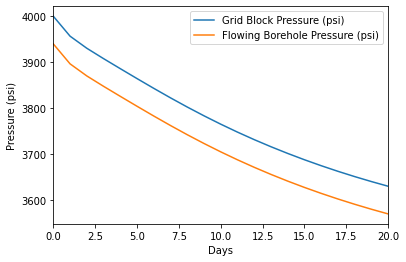

,time (day),grid block pressure (psi),fbhp_sol (psi),rate_sol (STB/D)
0,0,4000.000000,3939.906532,-150.0
1,1,3956.725827,3896.632359,-150.0
2,2,3930.495636,3870.402168,-150.0
3,3,3907.963692,3847.870224,-150.0
4,4,3886.187748,3826.094280,-150.0
5,5,3864.647503,3804.554035,-150.0
6,6,3843.447859,3783.354391,-150.0
7,7,3822.802040,3762.708572,-150.0
8,8,3802.886974,3742.793506,-150.0
9,9,3783.817248,3723.723780,-150.0


In [30]:
"""""""""""
WELL SIMULATION
"""""""""""

well_report = well1d_report_slicomp('B', wells, well_df, p_sol_record, p_initial, schedule)

plt.plot(well_report['time (day)'], well_report['grid block pressure (psi)'], label='Grid Block Pressure (psi)')
plt.plot(well_report['time (day)'], well_report['fbhp_sol (psi)'], label='Flowing Borehole Pressure (psi)')
plt.xlabel('Days'); plt.ylabel('Pressure (psi)')
plt.xlim(0, schedule)
plt.legend()
plt.show()

well_report